## Code for recreating the Vertical Profiles of relevant melt rate values and Melt rate comparison between parameterized and models

You will need to download 'revised_stat' and adjust the path for the script to run. To do the steady state solver comparison, you will need to download the 'steadyState' folder. All code is written by Madie Mamer (mmamer3@gatech.edu).

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import matplotlib.colors
import cmocean as cmo
import cmasher as cmr
from matplotlib.legend_handler import HandlerTuple

In [39]:
path = 'revised_stat/'
f2cu2_ice = pd.read_csv(path + 'f2cu2_bf_avg_ice.csv')
f4cu2_ice = pd.read_csv(path + 'f4cu2_bf_avg_ice.csv')
f5cu2_ice = pd.read_csv(path + 'f5cu2_bf_avg_ice.csv')

F2cu2_bf_body = pd.read_csv(path + 'f2cu2_bf_avg_body.csv')
F4cu2_bf_body = pd.read_csv(path + 'f4cu2_bf_avg_body.csv')
F5cu2_bf_body = pd.read_csv(path + 'f5cu2_bf_avg_body.csv')

sec_to_year = 3*10**7

## meltSensitivity_J11 Function

This function requires inputs yPoint and data. yPoint is the position of interest for the vertical profile and data is the domain body data in form FXcuY_body. This function finds the data points that satisfy the yPoint condition and calculate the shear velocity, heat transfer coefficients, and melt rate using the reduced form of the jenkins 2011/2010/ Holland and Jenkins 1999 parameterization. It returns individual arrays for each of the variables of interest.

In [40]:
def meltSensitivity_J11(yPoint, data):
    nu = 1.95 * 10 **(-6)

    new = data.iloc[np.where(data['x'].round(2) == yPoint)]
    
    u = np.array(new['avg_xVel'][::-1])
    salt =  np.array(new['avgSalt'][::-1])
    temp =  np.array(new['avgTemp'][::-1])
    rho =  np.array(new['avgDense'][::-1])
    y =  np.array(new['y'][::-1])
    u_wall = u[0]
    salt_wall = salt[0]
    temp_wall = temp[0]
    rho_wall = rho[0]
    y_wall = y[0]
    Pr = 13.8
    Sc = 2432
    cp = 2009
    L_i = 334000
    rho_i = 918
    melt_temp = np.zeros(len(y))
    melt_salt = np.zeros(len(y))
    gamma_temp = np.zeros(len(y))
    gamma_salt = np.zeros(len(y))
    ushear_arr = np.zeros(len(y))
    Cd = np.zeros(len(y))
    for i in range(0,len(y)):
        uShear = np.sqrt(nu * (abs(u[i]) - u_wall) / abs(y[i] - y_wall))
        dist = y_wall - y[i]
        gammaT = uShear / (2.12 * np.log(uShear * dist / nu) + 12.5 \
                           * Pr**(2/3) - 9)
        gammaS = uShear / (2.12 * np.log(uShear * dist / nu) + 12.5 \
                           * Sc**(2/3) - 9)
        mT = rho[i] * cp * gammaT * (temp[i] - temp_wall) / (L_i * rho_i)
        mS = rho[i] * gammaS * (salt[i] - salt_wall) / (salt_wall * rho_i)
        melt_temp[i] = mT
        melt_salt[i] = mS
        ushear_arr[i] = uShear
        gamma_temp[i] = gammaT
        gamma_salt[i] = gammaS
    return len(y),y, melt_temp, melt_salt, ushear_arr, gamma_temp, gamma_salt, u

#y_noMelt, meltTemp_noMelt, meltSalt_noMelt, ushear_noMelt, gammaTemp_noMelt, gammaSalt_noMelt, u_noMelt = meltSensitivity(2.5)
locs = [2.2,2.4,2.6,2.8,3.0,3.2,3.4,3.6,3.8,4.0]
ys = np.zeros((len(locs),1000)) * np.nan
meltTemp = np.zeros((len(locs),1000))* np.nan
meltSalt = np.zeros((len(locs),1000))* np.nan
ushear = np.zeros((len(locs),1000))* np.nan
gammaT = np.zeros((len(locs),1000))* np.nan
gammaS = np.zeros((len(locs),1000))* np.nan
us = np.zeros((len(locs),1000))* np.nan
num = 0
for i in range(0,len(locs)):
    num, ys[i,0:num], meltTemp[i,0:num], meltSalt[i,0:num], ushear[i,0:num], gammaT[i,0:num], gammaS[i,0:num], us[i,0:num] = meltSensitivity_J11(locs[i], F2cu2_bf_body)


/var/folders/z2/cy5n8j017z34kdvp0xbq27bh02w58x/T/ipykernel_5192/1672046953.py:28: RuntimeWarning: invalid value encountered in scalar divide
  uShear = np.sqrt(nu * (abs(u[i]) - u_wall) / abs(y[i] - y_wall))
/var/folders/z2/cy5n8j017z34kdvp0xbq27bh02w58x/T/ipykernel_5192/1672046953.py:28: RuntimeWarning: divide by zero encountered in scalar divide
  uShear = np.sqrt(nu * (abs(u[i]) - u_wall) / abs(y[i] - y_wall))
/var/folders/z2/cy5n8j017z34kdvp0xbq27bh02w58x/T/ipykernel_5192/1672046953.py:28: RuntimeWarning: invalid value encountered in sqrt
  uShear = np.sqrt(nu * (abs(u[i]) - u_wall) / abs(y[i] - y_wall))
/var/folders/z2/cy5n8j017z34kdvp0xbq27bh02w58x/T/ipykernel_5192/1672046953.py:30: RuntimeWarning: invalid value encountered in scalar multiply
  gammaT = uShear / (2.12 * np.log(uShear * dist / nu) + 12.5 \
/var/folders/z2/cy5n8j017z34kdvp0xbq27bh02w58x/T/ipykernel_5192/1672046953.py:32: RuntimeWarning: invalid value encountered in scalar multiply
  gammaS = uShear / (2.12 * np.log

## meltSensitvity_DDC Function

This function takes in yPoint and data. yPoint is the position of interest for the vertical profile and data is the domain time averaged data. This function calcualtes the temperature and salinity gradients for the vertical profile to obtain a melt rate based on the double diffusive framework. It returns all variables as their own arrays.

In [41]:
def meltSensitivity_DDC(yPoint, data):

    new = data.iloc[np.where(data['x'].round(2) == yPoint)]

    u = np.array(new['avg_xVel'][::-1])
    salt =  np.array(new['avgSalt'][::-1])
    temp =  np.array(new['avgTemp'][::-1])
    rho =  np.array(new['avgDense'][::-1])
    y =  np.array(new['y'][::-1])
    u_wall = u[0]
    salt_wall = salt[0]
    temp_wall = temp[0]
    rho_wall = rho[0]
    y_wall = y[0]
    Pr = 13.8
    Sc = 2432
    cp = 2009
    L_i = 334000
    rho_i = 918
    melt_temp = np.zeros(len(y))
    melt_salt = np.zeros(len(y))
    gamma_temp = np.zeros(len(y))
    gamma_salt = np.zeros(len(y))
    ushear_arr = np.zeros(len(y))
    Q_h = np.zeros(len(y))
    K_T = 1.4 * 10 **(-7)
    K_S = 1.3 * 10**(-9)
    
    for i in range(0,len(y)):
        t = np.linspace(y_wall, y[i], i)
        A = np.vstack([t, np.ones(i)]).T
        dTdz, cT = np.linalg.lstsq(A, temp[0:i], rcond=None)[0]
        dSdz, cS = np.linalg.lstsq(A, salt[0:i], rcond=None)[0]
        m_T = -rho[i] * cp * K_T * dTdz / (L_i * rho_i)
        m_S = -rho[i] * K_S * dSdz / (rho_i * salt_wall)
        melt_temp[i] = m_T
        melt_salt[i] = m_S
        Q_h[i] = rho[i] * cp * K_T * dTdz
    return len(y), y, melt_temp, melt_salt, temp, Q_h
locs = [2.2,2.4,2.6,2.8,3.0,3.2,3.4,3.6,3.8,4.0]
ys = np.zeros((len(locs),1000)) * np.nan
melt_temp = np.zeros((len(locs),1000))* np.nan
melt_salt = np.zeros((len(locs),1000))* np.nan
temps = np.zeros((len(locs),1000))* np.nan
Q_h = np.zeros((len(locs),1000))* np.nan
num = 0
for i in range(0,len(locs)):
    num, ys[i,0:num], melt_temp[i,0:num], melt_salt[i,0:num], temps[i,0:num], Q_h[i,0:num] = meltSensitivity_DDC(locs[i], F2cu2_bf_body)


/var/folders/z2/cy5n8j017z34kdvp0xbq27bh02w58x/T/ipykernel_5192/1880833797.py:35: RuntimeWarning: invalid value encountered in scalar divide
  m_S = -rho[i] * K_S * dSdz / (rho_i * salt_wall)
/var/folders/z2/cy5n8j017z34kdvp0xbq27bh02w58x/T/ipykernel_5192/1880833797.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  m_S = -rho[i] * K_S * dSdz / (rho_i * salt_wall)


In [26]:
def meltSensitivity_Conv(yPoint, data):

    new = data.iloc[np.where(data['x'].round(2) == yPoint)]

    salt =  np.array(new['avgSalt'][::-1])
    temp =  np.array(new['avgTemp'][::-1])
    rho =  np.array(new['avgDense'][::-1])
    y =  np.array(new['y'][::-1])
    
    salt_wall = salt[0]
    temp_wall = temp[0]
    rho_wall = rho[0]
    y_wall = y[0]
    
    c_i = 918
    rho_w = 1020
    c_w = 2009
    L_i = 334000
    rho_i = 918
    g = 9.81
    nu = 1.95 * 10**(-6)
    melt_temp = np.zeros(len(y))
    melt_salt = np.zeros(len(y))
    gamma_temp = np.zeros(len(y))
    gamma_salt = np.zeros(len(y))
    ushear_arr = np.zeros(len(y))
    K_T = 1.4 * 10 **(-7)
    K_S = 1.3 * 10**(-9)
    theta = 45 * np.pi/180
    gamma = 0.09
    
    for i in range(0,len(y)):
        rho_w = rho[i]
        salt_w = salt[i]
        t = np.linspace(y_wall, y[i], i)
        A = np.vstack([t, np.ones(i)]).T
        m_T = gamma * np.sin(theta)**(2/3) * ( (g * (rho_w - rho_wall) * K_S**2) / (rho_w * nu) ) * ( (salt_w - salt_wall) / (salt_w - 0))
        #m_S = -rho[i] * K_S * dSdz / (rho_i * salt_wall)
        melt_temp[i] = m_T
    return len(y), y, melt_temp, melt_salt, temp
locs = [2.2,2.4,2.6,2.8,3.0,3.2,3.4,3.6,3.8,4.0]
ys = np.zeros((len(locs),1000)) * np.nan
melt_temp = np.zeros((len(locs),1000))* np.nan
melt_salt = np.zeros((len(locs),1000))* np.nan
temps = np.zeros((len(locs),1000))* np.nan
num = 0
for i in range(0,len(locs)):
    num, ys[i,0:num], melt_temp[i,0:num], melt_salt[i,0:num], temps[i,0:num] = meltSensitivity_Conv(locs[i], F2cu2_bf_body)


/var/folders/z2/cy5n8j017z34kdvp0xbq27bh02w58x/T/ipykernel_40241/3571811054.py:37: RuntimeWarning: invalid value encountered in scalar divide
  m_T = gamma * np.sin(theta)**(2/3) * ( (g * (rho_w - rho_wall) * K_S**2) / (rho_w * nu) ) * ( (salt_w - salt_wall) / (salt_w - 0))


## Vertical Profiles of Parameterized Values

Below is a script that plots the sensitivity to melt rates and turbulent transfer parameters based on the reference location within the water column. 

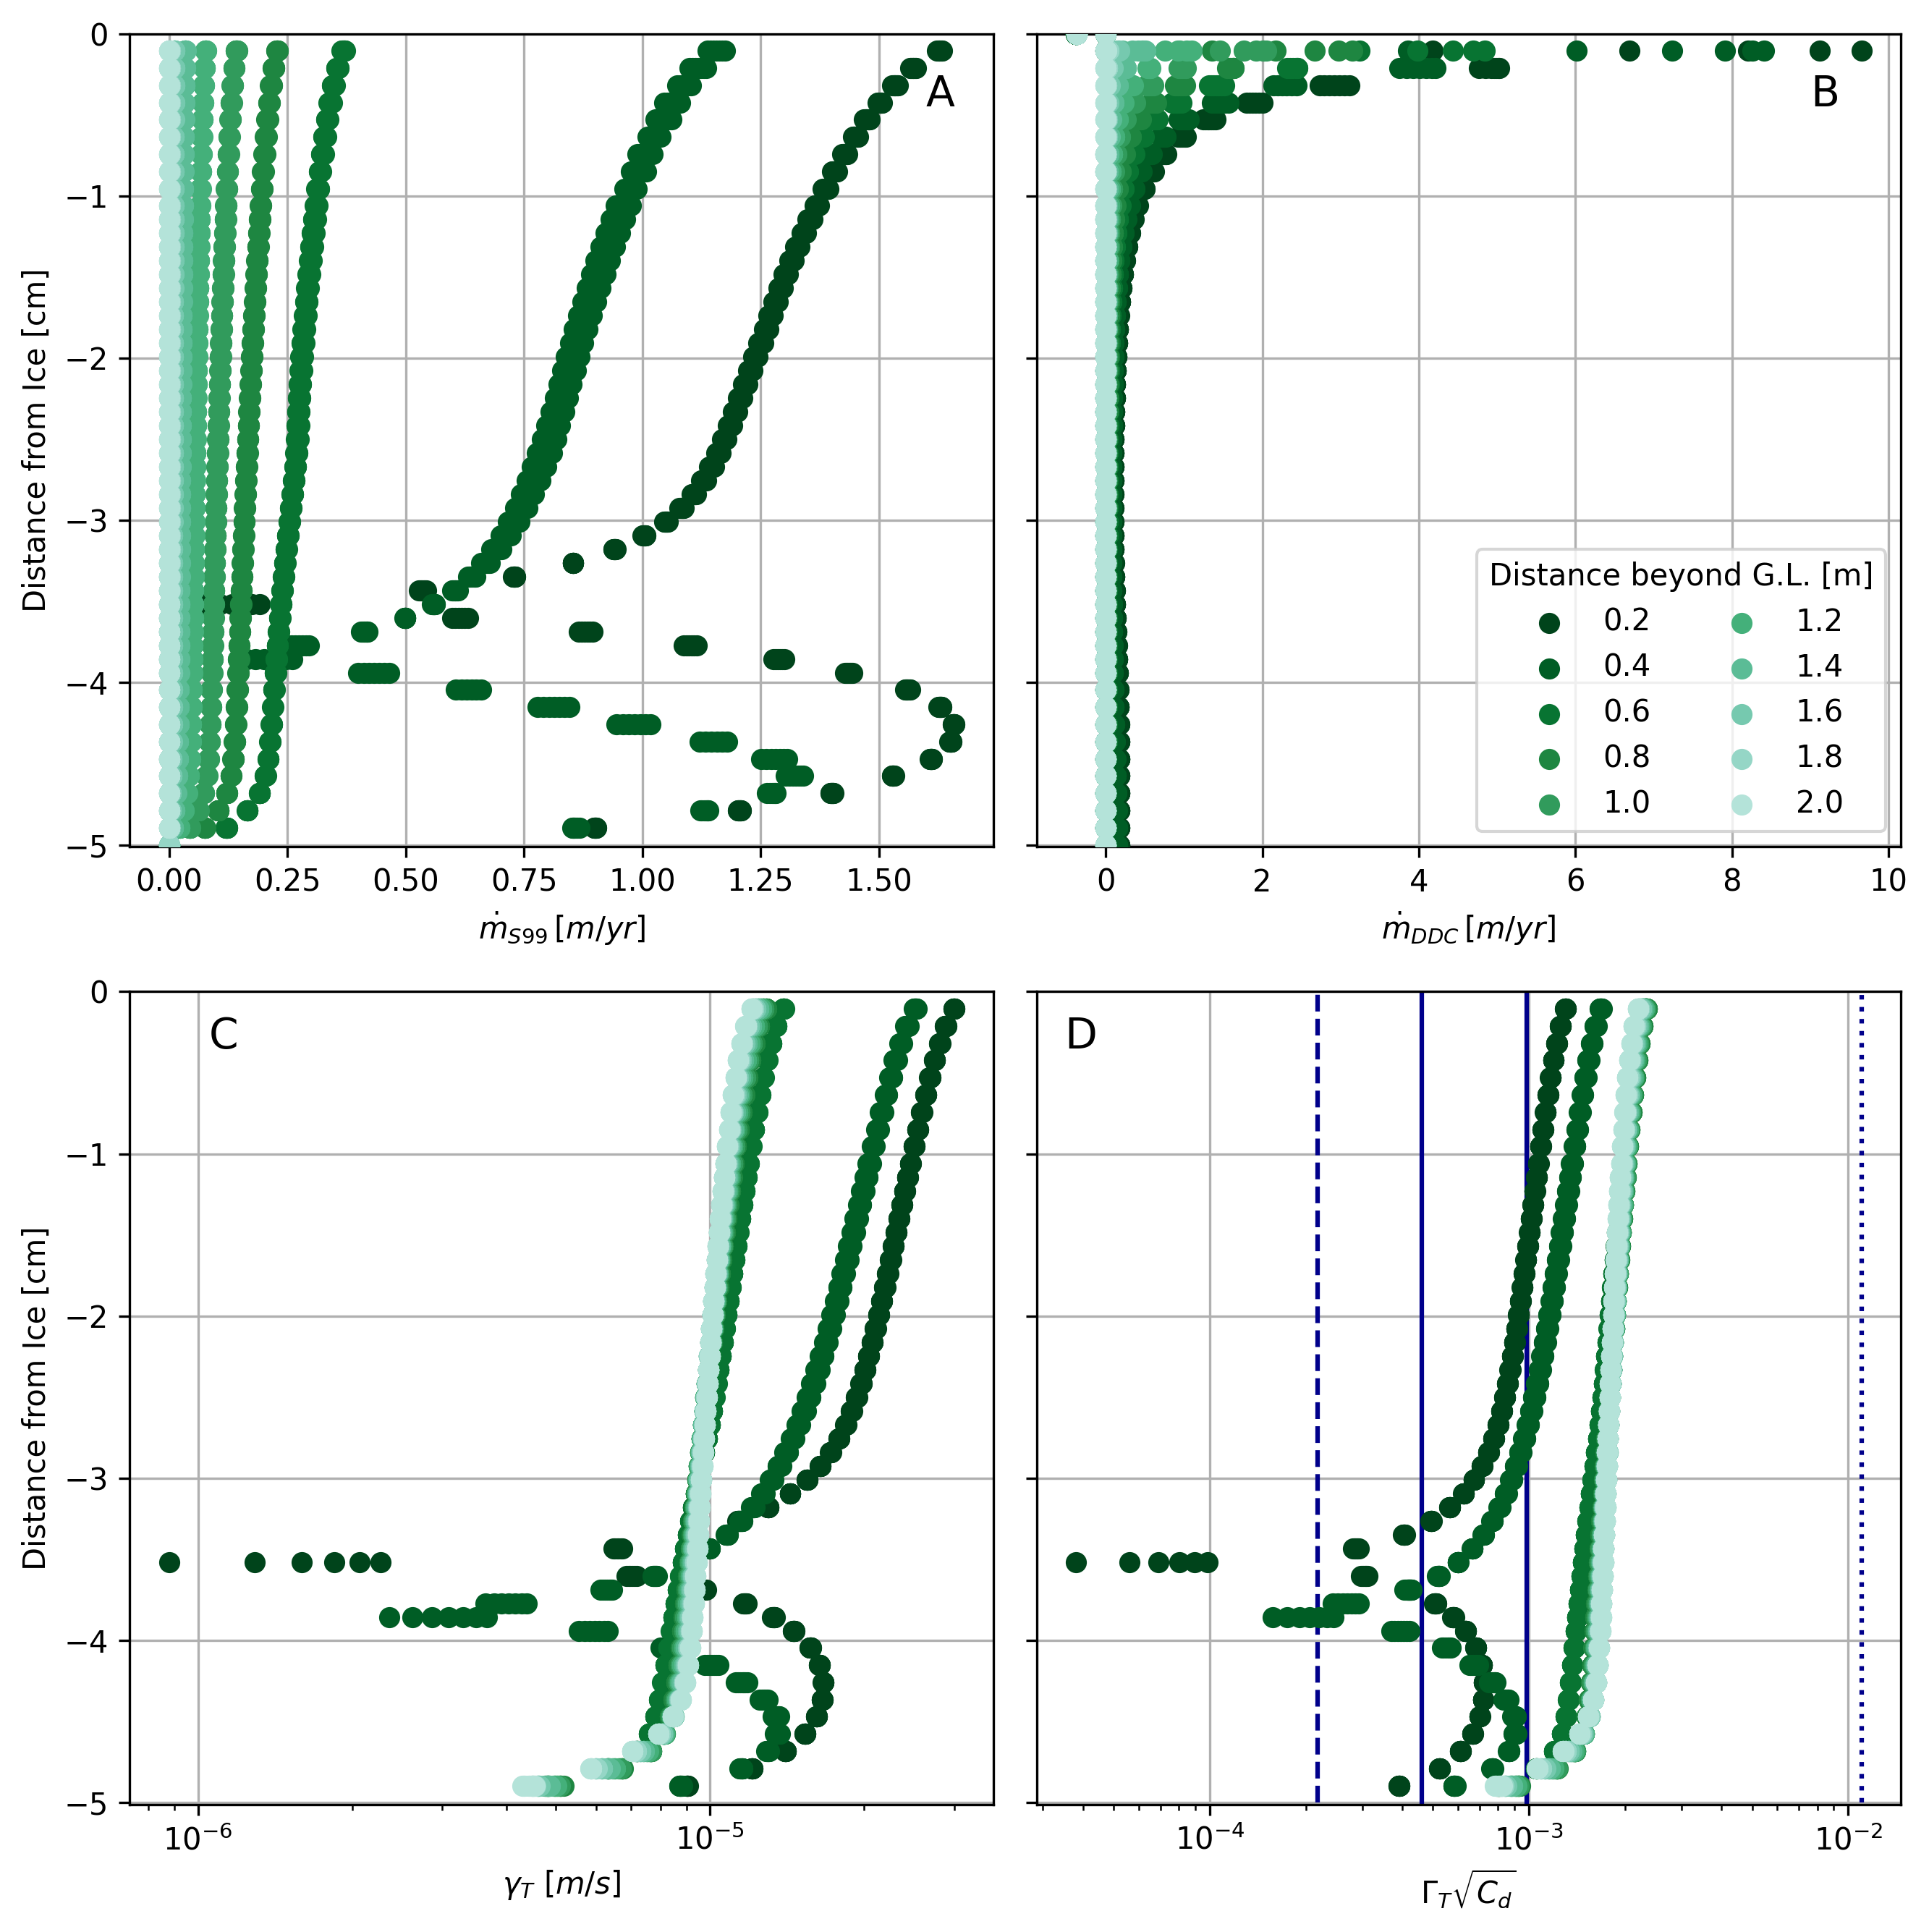

In [42]:
fig, ax = plt.subplots(2,2, figsize = (9,9),dpi = 300)
ax1 = ax[0,0]
ax2 = ax[1,0]
ax3 = ax[1,1]
ax4 = ax[0,1]
sec_to_year = 3*10**7
colors = plt.get_cmap('BuGn_r',len(locs)+4)
#['midnightblue', 'mediumblue', 'royalblue','dodgerblue','lightskyblue']

for i in range(0,len(locs)):
    m_J11 = ax1.scatter(meltTemp[i]*sec_to_year, (ys[i] - 0.05)*100, color = colors(i),zorder=3)
    gT = ax2.scatter(gammaT[i], (ys[i]-0.05)*100, color = colors(i),zorder=3)
    maxFresh_u = np.nanmax(abs(us[i,np.where(ys[i] >= 0.025)]))
    gS = ax3.scatter(gammaT[i]/maxFresh_u, (ys[i] - 0.05)*100, color = colors(i),zorder=3)
    m_DDC = ax4.scatter(melt_temp[i]*sec_to_year, (ys[i] - 0.05)*100, color = colors(i), zorder = 3)

ax4.grid(zorder = 1); #ax4.set_xlim(-0.25,10)

j10 = ax3.plot(np.ones(10) * 11*10**(-3), np.linspace(-5,0,10), linestyle = ':', color = 'darkblue', zorder=2); #Jenkins 2010
wSc23 = ax3.plot(np.ones(10) * 9.85*10**(-4),  np.linspace(-5,0,10), 'darkblue', zorder=2); #washam scallops 2023
wRu23 = ax3.plot(np.ones(10) * 4.61*10**(-4),  np.linspace(-5,0,10), 'darkblue', zorder=2); #washam runnels 2023
w20 = ax3.plot(np.ones(10) * 2.18*10**(-4),  np.linspace(-5,0,10), linestyle = '--', color =  'darkblue', zorder=2); #washam 2020 tidal modulation

#ax3.legend([j10,wSc23,wRu23, w20],['Jenkins et al. 2010', 'Washam et al. 2023 Scallops', 'Washam et al. 2023 Runnels', 'Washam et al. 2020'])
ax1.set_ylim(-5.01,0); ax2.set_ylim(-5.01,0); ax3.set_ylim(-5.01,0);ax4.set_ylim(-5.01,0);
ax1.grid(zorder = 1); ax2.grid(zorder = 1); ax3.grid(zorder = 1);
ax3.set_yticklabels([]); ax4.set_yticklabels([])
ax1.set_xlabel('$\dot{m}_{S99} \, [m/yr]$'); ax2.set_xlabel('$\gamma_T \, \, [m/s$]'); 
ax3.set_xlabel('$\Gamma_T \sqrt{C_d}$')
ax4.set_xlabel('$\dot{m}_{DDC} \, [m/yr]$')
ax1.set_ylabel('Distance from Ice [cm]'); ax2.set_ylabel('Distance from Ice [cm]');
ax3.set_xscale('log')
locs_label = np.subtract(locs, 2).round(2);
ax4.legend(locs_label,loc = 'lower right',ncols = 2, title = 'Distance beyond G.L. [m]')
#plt.colorbar(colors)

ax1.text(1.6,-0.45,'A',fontsize = 14); ax2.text(0.00000105, -0.35, 'C',fontsize = 14); 
ax3.text(0.000035,-0.35,'D',fontsize = 14); ax4.text(9,-0.45,'B',fontsize = 14,zorder=3);

#ax1.set_ylim(ax1.get_ylim()[::-1]); ax2.set_ylim(ax2.get_ylim()[::-1]);
#ax3.set_ylim(ax3.get_ylim()[::-1]); ax4.set_ylim(ax4.get_ylim()[::-1]);
ax2.set_xscale('log')

plt.tight_layout();
plt.savefig('melt_distFromWall.png',facecolor = 'white',dpi =500)



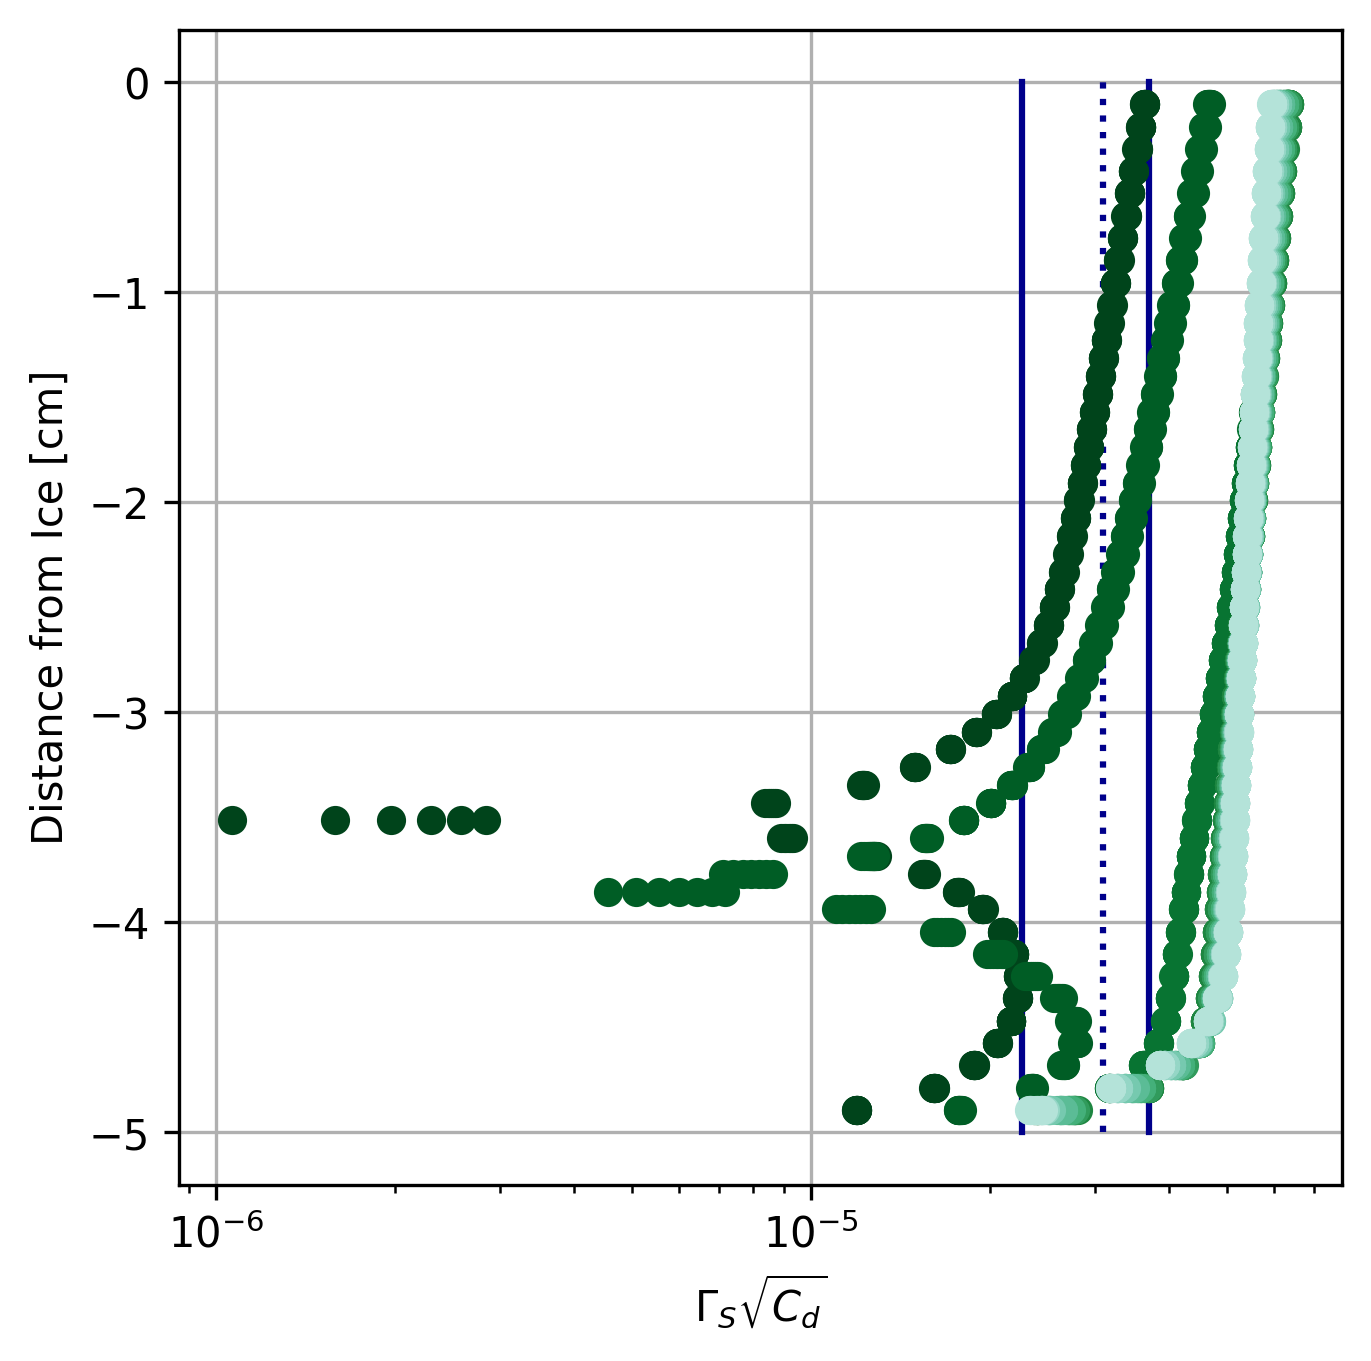

In [56]:
fig, ax = plt.subplots(1,1, figsize = (5,5), dpi = 300);

sec_to_year = 3*10**7
colors = plt.get_cmap('BuGn_r',len(locs)+4)
#['midnightblue', 'mediumblue', 'royalblue','dodgerblue','lightskyblue']

for i in range(0,len(locs)):
    maxFresh_u = np.nanmax(abs(us[i,np.where(ys[i] >= 0.025)]))
    gS = ax.scatter(gammaS[i]/maxFresh_u, (ys[i] - 0.05)*100, color = colors(i),zorder=3)

wSc23 = ax.plot(np.ones(10) * 3.7*10**(-5),  np.linspace(-5,0,10), 'darkblue', zorder=2); #washam scallops 2023
wRu23 = ax.plot(np.ones(10) * 2.26*10**(-5),  np.linspace(-5,0,10), 'darkblue', zorder=2); #washam runnels 2023
j10 = ax.plot(np.ones(10) * 3.1*10**(-5), np.linspace(-5,0,10), linestyle = ':', color = 'darkblue', zorder=2); #Jenkins 2010

ax.set_xscale('log')
ax.set_xlabel('$\Gamma_S \sqrt{C_d}$')
ax.set_ylabel('Distance from Ice [cm]');
ax.grid()

plt.savefig('halineStantonNum.png', dpi = 500);

### Comparison of modeled melt rates and parameterized calculations

Below is the script to recreate the modeled melt rate vs parameterized melt rates. 

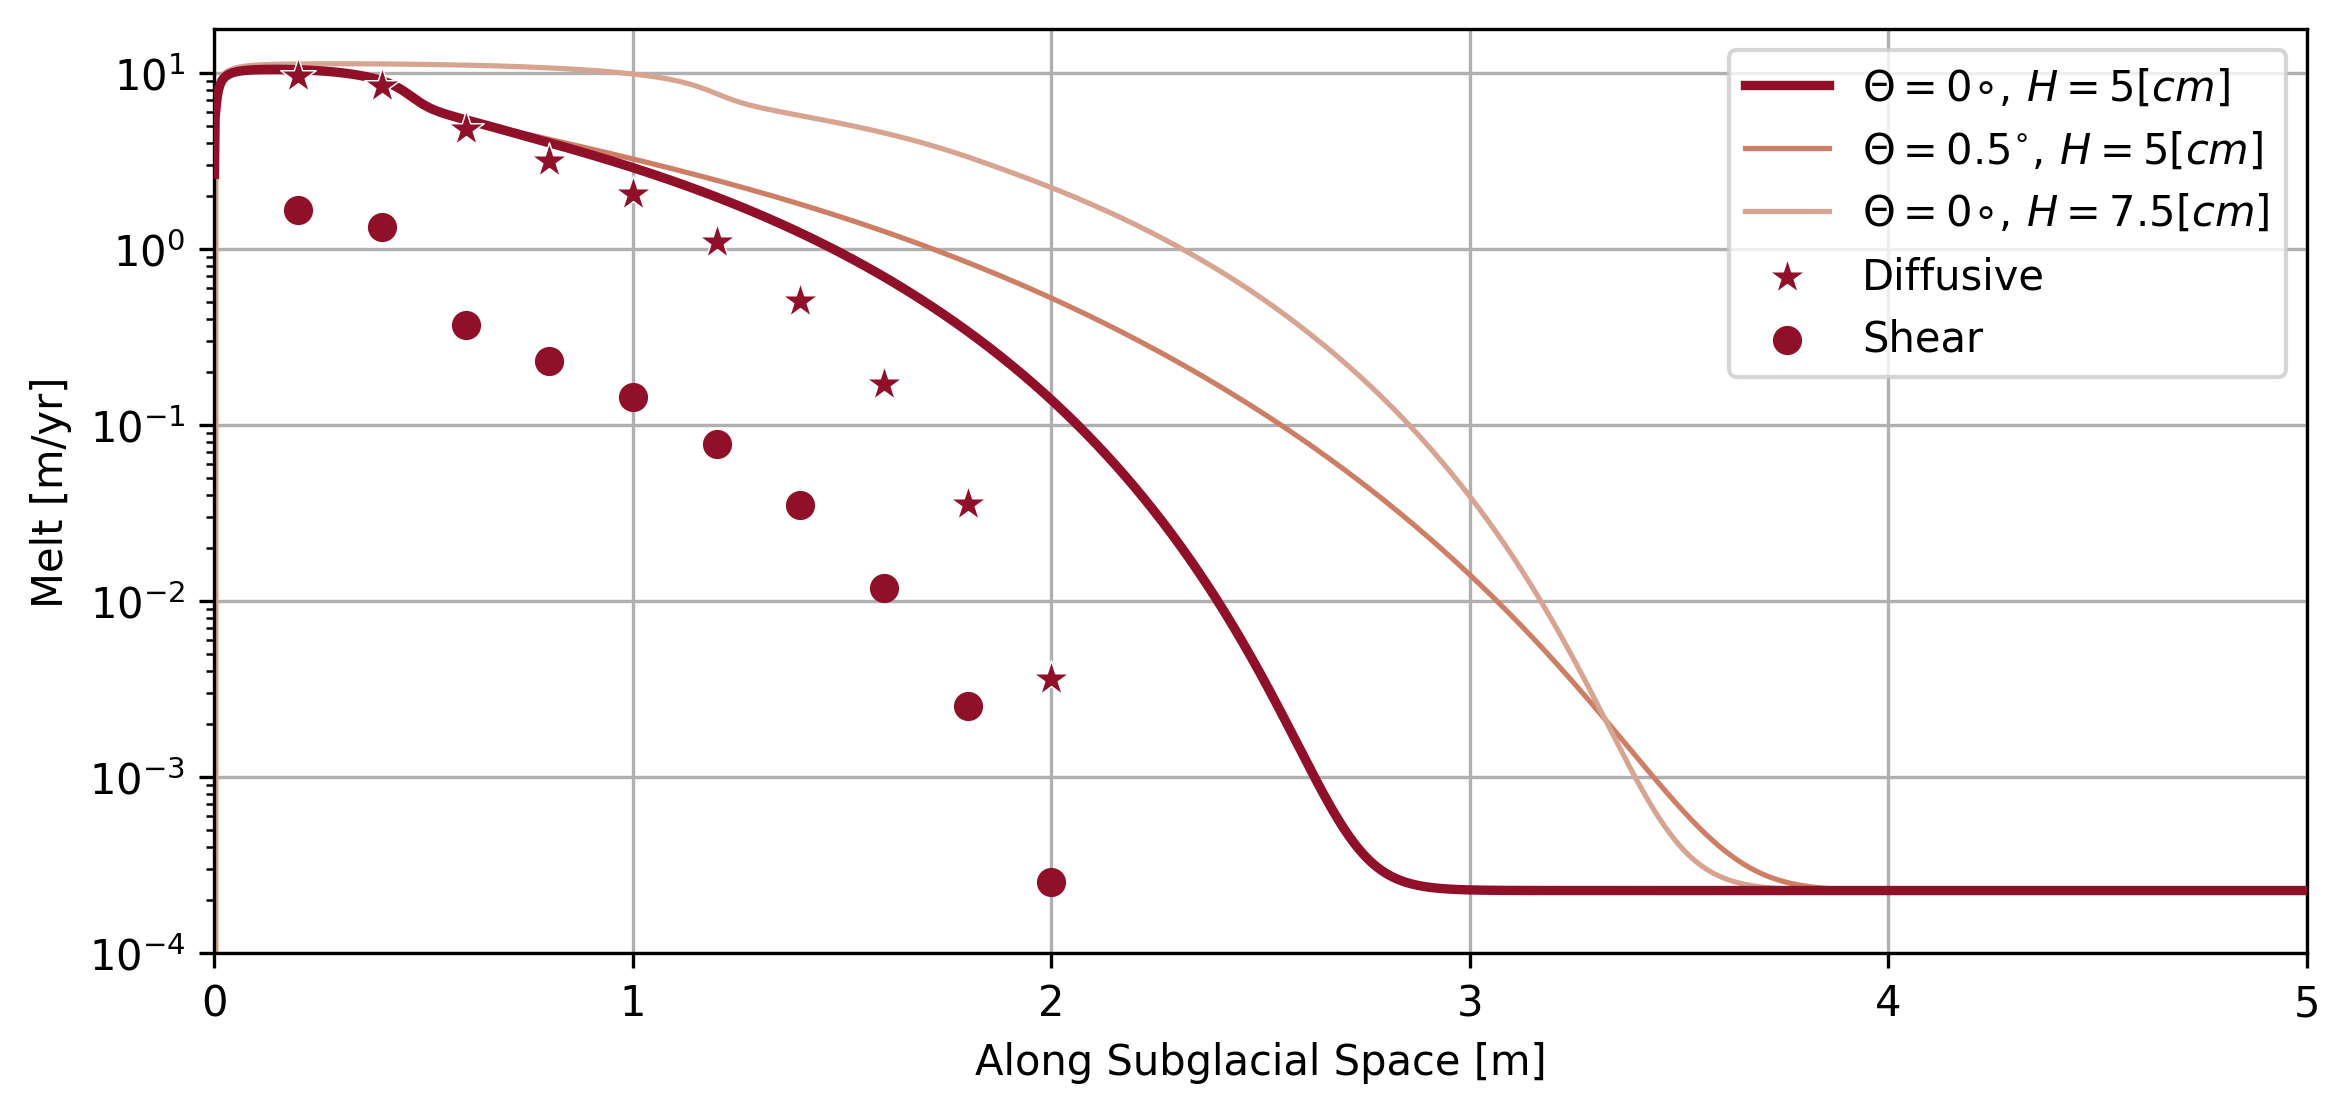

In [43]:
fig, ax = plt.subplots(1, figsize = (9,4), dpi = 300)
#locs = [2.2,2.4,2.6,2.8,3.0,3.2,3.4,3.6,3.8,4.0]
colors = cmo.cm.amp_r(np.linspace(0,1,9))
f2, = ax.plot(f2cu2_ice['x']-2, -f2cu2_ice['avgMelt'] * sec_to_year, color = colors[2], linewidth = 2.25, zorder = 4)
f4, = ax.plot(f4cu2_ice['x']-2, -f4cu2_ice['avgMelt'] * sec_to_year, color = colors[5], linewidth = 1.25, zorder = 2)
f5, = ax.plot(f5cu2_ice['x']-2, -f5cu2_ice['avgMelt'] * sec_to_year, color = colors[6], linewidth = 1.25, zorder = 2)

locs2 = np.subtract(locs,2)
diff = ax.scatter(locs2, np.nanmax(melt_temp, axis = 1) * sec_to_year, marker = '*', edgecolor = 'white',\
           linewidth = 0.35, s = 80, color = colors[2], zorder = 4)
shear = ax.scatter(locs2, np.nanmax(meltTemp, axis = 1) * sec_to_year, marker = 'o', color = colors[2], zorder = 3);

ax.set_yscale('log'); ax.set_ylim(10**(-4), 10**(1.25)); 
ax.set_xlim(0,5);

ax.set_xlabel('Along Subglacial Space [m]'); ax.set_ylabel('Melt [m/yr]'); ax.grid(zorder = 1);
ax.legend([f2,f4,f5,diff,shear], ['$\Theta = 0{\circ}, \, H = 5 [cm]$', \
           '$\Theta = 0.5^{\circ}, \, H = 5 [cm]$', '$\Theta = 0{\circ}, \, H = 7.5 [cm]$', 'Diffusive','Shear']);
plt.savefig('melt.png',dpi = 500)

## Comparison of Steady state solver and transient average for melt rates

In [44]:
f2cu2_bf_ssPost_ice = pd.read_csv('steadyState/f2cu2_bf_ssPost_iceBottom')
f2cu2_bf_ssPre_ice = pd.read_csv('steadyState/f2cu2_bf_ssPre_iceBottom')


f4cu2_bf_ssPost_ice = pd.read_csv('steadyState/f4cu2_bf_ssPost_iceBottom')
f4cu2_bf_ssPre_ice = pd.read_csv('steadyState/f4cu2_bf_ssPre_iceBottom')


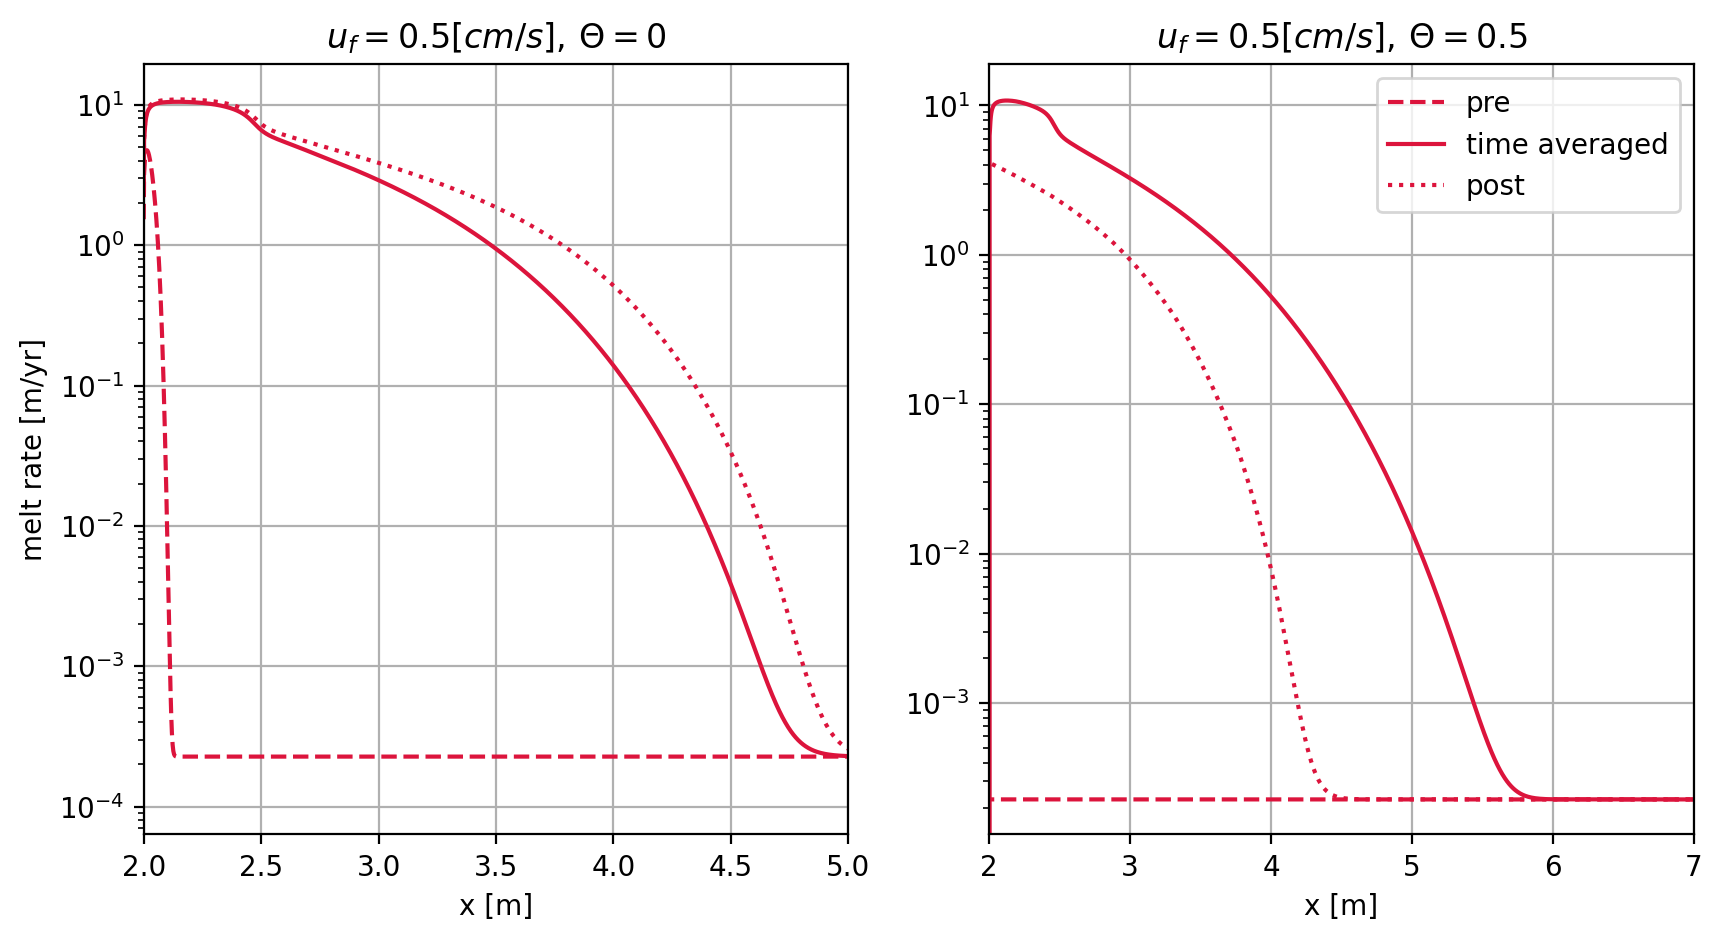

In [46]:
fig,ax = plt.subplots(1,2, figsize = (10,5), dpi = 200)

ax[0].plot(f2cu2_bf_ssPre_ice['    x-coordinate'], -1 * f2cu2_bf_ssPre_ice['      y-velocity']*sec_to_year, linestyle = '--', color = 'crimson')
ax[0].plot(f2cu2_ice['x'], -1*f2cu2_ice['avgMelt']* sec_to_year, color = 'crimson')
ax[0].plot(f2cu2_bf_ssPost_ice['    x-coordinate'], -1 * f2cu2_bf_ssPost_ice['      y-velocity']*sec_to_year, linestyle = ':', color = 'crimson')

ax[1].plot(f4cu2_bf_ssPre_ice['    x-coordinate'], -1 * f4cu2_bf_ssPre_ice['      y-velocity']*sec_to_year, linestyle = '--', color = 'crimson')
ax[1].plot(f4cu2_ice['x'], -1*f4cu2_ice['avgMelt']*sec_to_year, color = 'crimson')
ax[1].plot(f4cu2_bf_ssPost_ice['    x-coordinate'], -1 * f4cu2_bf_ssPost_ice['      y-velocity']*sec_to_year, linestyle = ':', color = 'crimson')

ax[0].set_xlabel('x [m]'); ax[1].set_xlabel('x [m]')
ax[0].set_ylabel('melt rate [m/yr]')
ax[0].set_yscale('log'); ax[1].set_yscale('log');
ax[0].set_xlim(2,5); ax[1].set_xlim(2,7); 
ax[0].grid(); ax[1].grid();
ax[1].legend(['pre','time averaged', 'post']);

ax[0].set_title("$u_f = 0.5 [cm/s], \, \Theta = 0$");
ax[1].set_title("$u_f = 0.5 [cm/s], \, \Theta = 0.5$");
